Double deep q learning

The difference between DDQN and DQN:
- In DQN, the same network is used to select the best action and to estimate the value of that action. This can lead to an overoptimistic estimation of Q-values, which may result in suboptimal policies.
- DDQN decouples the action selection and action value estimation by using two separate networks: the online Q-network (with weights θ) and the target Q-network (with weights θ').
  - the online Q-network is used to select the best action, the target Q-network is used to estimate the value of that action
  - the target value computation in DDQN is as follows:
    - use the online Q to select the best action
    - use the target Q to estimate the value of taking this action
    - compute the target value using Bellman optimality with the target Q-network
  - the online Q network is updated as DQN, and the target Q-network is updated periodically by copying the weights from the online Q-network.
 

In [1]:
import gymnasium as gym
import jax
import jax.numpy as jnp
import numpy as np
from collections import deque
import random
from flax import linen as nn
import optax
import matplotlib.pyplot as plt

/opt/conda/lib/python3.8/site-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(


In [2]:
class QNetwork(nn.Module):
    action_size: int
    
    def setup(self):
        self.dense1 = nn.Dense(features=64)
        self.dense2 = nn.Dense(features=64)
        self.dense3 = nn.Dense(features=self.action_size)

    def __call__(self, x):
        x = nn.relu(self.dense1(x))
        x = nn.relu(self.dense2(x))
        x = self.dense3(x)
        return x

In [3]:
class DDQNAgent:
    def __init__(self, state_size, action_size, rng_key, buffer_size=10000, batch_size=64, gamma=0.99, lr=1e-3, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.99):
        self.state_size = state_size
        self.action_size = action_size
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.lr = lr
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.memory = deque(maxlen=buffer_size)

        rng_key, rng_key_init = jax.random.split(rng_key)
        self.network, self.params, self.optimizer, self.opt_state = self.initialize_network_and_optimizer(rng_key_init)
        self.target_params = self.params
        self.tau = 0.001
        self.steps = 0

        # debug
        self.losses = []
        self.grads = []
    
    def initialize_network_and_optimizer(self, rng):
        network = QNetwork(self.action_size)
        params = network.init(rng, jnp.ones((self.state_size,)))
        optimizer = optax.adam(self.lr)
        opt_state = optimizer.init(params)
        return network, params, optimizer, opt_state

    def sync_target(self):
        #self.target_params = self.params
        # this is soft update for each step
        self.target_params = jax.tree_map(lambda x, y: self.tau * x + (1 - self.tau) * y, self.params, self.target_params)

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randint(0, self.action_size - 1)
        else:
            state = jnp.expand_dims(jnp.array(state, dtype=jnp.float32), axis=0)
            q_values = self.network.apply(self.params, state)
            return int(jnp.argmax(q_values))

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))

        states = jnp.array(states, dtype=jnp.float32)
        actions = jnp.array(actions, dtype=jnp.int32)
        rewards = jnp.array(rewards, dtype=jnp.float32)
        next_states = jnp.array(next_states, dtype=jnp.float32)
        dones = jnp.array(dones, dtype=jnp.float32)

        def loss(params):
            # (s,a,r,s')
            # Q(s)
            q_values = self.network.apply(params, states)
            # Q(s,a)
            q_values = jnp.take_along_axis(q_values, actions[:, None], axis=-1).squeeze()#jax.vmap(lambda s: s[actions])(q_values)

            # Q(s')
            online_q_next = self.network.apply(params, next_states)
            # Q'(s')
            target_q_next = self.network.apply(self.target_params, next_states)
            
            # a' = argmax_a(Q(s'))
            next_action = jnp.argmax(online_q_next, axis=-1)
            # Q'(s', a')
            q_target_next = jnp.take_along_axis(target_q_next, next_action[:, None], axis=-1).squeeze()
            # target: r + gamma*Q'(s', a')
            targets = rewards + self.gamma * (1 - dones) * q_target_next
            
            return jnp.mean((targets - q_values) ** 2)

        grad_fn = jax.value_and_grad(loss)
        loss_value, gradients = grad_fn(self.params)
        updates, self.opt_state = self.optimizer.update(gradients, self.opt_state)
        self.params = optax.apply_updates(self.params, updates)
        self.losses.append(loss_value)
        self.grads.append(gradients)
        #self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)
        #print(self.epsilon)
        self.steps += 1


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Episode 0, Total Reward: 12.0
Episode 1, Total Reward: 21.0
Episode 2, Total Reward: 15.0
Episode 3, Total Reward: 20.0
Episode 4, Total Reward: 9.0
Episode 5, Total Reward: 20.0
Episode 6, Total Reward: 41.0
Episode 7, Total Reward: 22.0
Episode 8, Total Reward: 22.0
Episode 9, Total Reward: 19.0
Episode 10, Total Reward: 11.0
Episode 11, Total Reward: 32.0
Episode 12, Total Reward: 27.0
Episode 13, Total Reward: 16.0
Episode 14, Total Reward: 30.0
Episode 15, Total Reward: 26.0
Episode 16, Total Reward: 12.0
Episode 17, Total Reward: 48.0
Episode 18, Total Reward: 16.0
Episode 19, Total Reward: 22.0
Episode 20, Total Reward: 17.0
Episode 21, Total Reward: 28.0
Episode 22, Total Reward: 18.0
Episode 23, Total Reward: 12.0
Episode 24, Total Reward: 33.0
Episode 25, Total Reward: 46.0
Episode 26, Total Reward: 29.0
Episode 27, Total Reward: 33.0
Episode 28, Total Reward: 34.0
Episode 29, Total Reward: 47.0
Episode 30, Total Reward: 30.0
Episode 31, Total Reward: 18.0
Episode 32, Total R

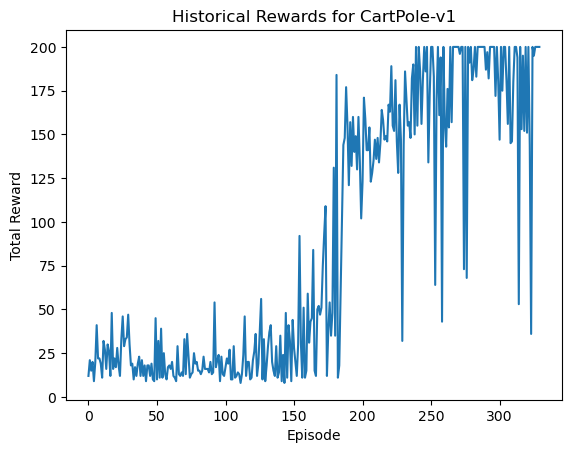

In [4]:
# Training and testing the DDQN agent
env = gym.make("CartPole-v1", render_mode="rgb_array").env
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
rng_key = jax.random.PRNGKey(42)
lr = 1e-03

agent = DDQNAgent(state_size, action_size, rng_key, lr=lr)

n_episodes = 500
reward_history = []
max_episode_steps=200 # env.spec.max_episode_steps
reward_threshold=175 # env.spec.reward_threshold
solved_window = 100
 
# sync target q-network
steps_since_target_update = 0
target_update_freq = 2

# main loop
for episode in range(n_episodes):
    state, _ = env.reset()
    state = jnp.array(state, dtype=jnp.float32)

    total_reward = 0
    done = False
    step_in_episode = 0
    
    while not done:
        action = agent.act(state)
        next_state, reward, done, _, _ = env.step(action)
        next_state = jnp.array(next_state, dtype=jnp.float32)

        agent.remember(state, action, reward, next_state, done)
        agent.replay()

        state = next_state
        total_reward += reward
        step_in_episode += 1

        # update  target q-network 
        steps_since_target_update += 1
        if steps_since_target_update >= target_update_freq:
            agent.sync_target()
            steps_since_target_update = 0

        # check if the max_episode_steps are met. if so, terminate this episode
        if step_in_episode >= max_episode_steps:
            print(f"Agent reached max_episode_steps in episode {episode}.")
            break
        
        # udpate epsiolon after episode
        if done:
            if agent.epsilon > agent.epsilon_end:
                agent.epsilon *= agent.epsilon_decay
    
    reward_history.append(total_reward)
    print(f"Episode {episode}, Total Reward: {total_reward}")

    # stop training if average reward reaches requirement
    # Calculate the average reward over the last 'solved_window' episodes
    if episode >= solved_window:
        avg_reward = np.mean(reward_history[-solved_window:])
        print(f'Episode: {episode}, Average Reward: {avg_reward}')

        if avg_reward >= reward_threshold:
            print(f"CartPole-v1 solved in {episode} episodes!")
            break

# Plot the historical rewards
plt.plot(reward_history)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Historical Rewards for CartPole-v1")
plt.show()

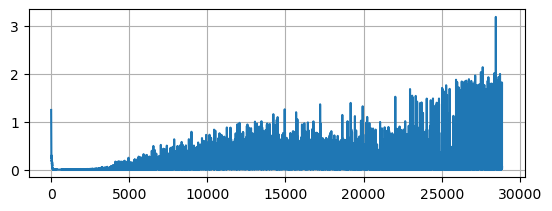

In [5]:
plt.figure()
plt.subplot(2,1,1)
plt.plot(agent.losses)
plt.grid()


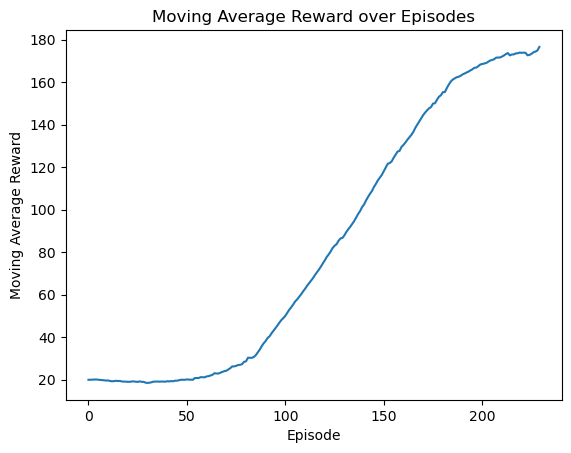

In [6]:
# plot training 
def plot_moving_average_reward(episode_rewards, window_size=100):
    cumsum_rewards = np.cumsum(episode_rewards)
    moving_avg_rewards = (cumsum_rewards[window_size:] - cumsum_rewards[:-window_size]) / window_size

    plt.plot(moving_avg_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Moving Average Reward')
    plt.title('Moving Average Reward over Episodes')
    plt.show()

plot_moving_average_reward(reward_history)


In [7]:
agent.steps

28863

Test Episode, Total Reward: 138.0


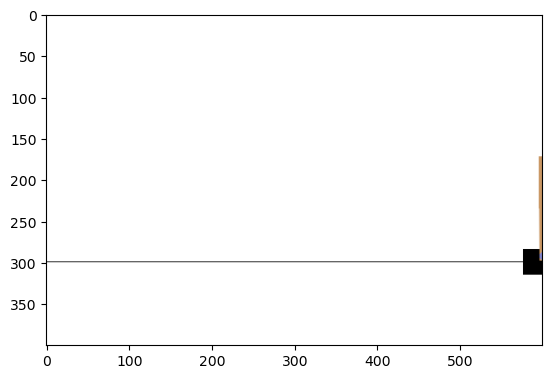

In [8]:
# test
# need a virtual display for rendering in docker
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()
from IPython import display as ipythondisplay

# Test the trained agent
print("\nTesting the trained agent...")

state, _ = env.reset()
state = jnp.array(state, dtype=jnp.float32)

total_reward = 0
done = False
step_in_episode = 0

pre_screen = env.render()
while not done:
    action = agent.act(state)
    next_state, reward, done, _, _ = env.step(action)
    next_state = jnp.array(next_state, dtype=jnp.float32)
    screen = env.render()
    state = next_state
    total_reward += reward
    step_in_episode += 1

    plt.imshow(screen)
    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())

    # check if the max_episode_steps are met. if so, terminate this episode
    if step_in_episode >= max_episode_steps:
        print(f"Agent reached max_episode_steps in episode {episode}.")
        break
    
ipythondisplay.clear_output(wait=True)

print(f"Test Episode, Total Reward: {total_reward}")

env.close()